# Analyzing the startup selling food products. Investigation of user behavior for the company's app.

In this project we have to prepare a report with the users behaviour for the company's app. We need to find out the share of users that go from main screen to the purhase screen and to check the equalty of groups.

In [1]:
import warnings 
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
!pip install -Uq matplotlib --user

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [3]:
!pip install -Uq plotly --user

In [4]:
!pip install -Uq seaborn --user

In [5]:
import pandas as pd 
import math as mth
from scipy import stats as st
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import datetime
from datetime import datetime

# Step 1

In [6]:
try:
    food_data = pd.read_csv('/datasets/logs_exp_us.csv', sep ='\t')
except IOError as e:
    print(e)


# Step 2. Preparing data for analysis

In [7]:
food_data.sample(5)

,EventName,DeviceIDHash,EventTimestamp,ExpId
226713,CartScreenAppear,8147206929408483621,1565179601,246
231029,CartScreenAppear,5131027327776247607,1565187454,246
105993,MainScreenAppear,6991683592829765144,1564861329,248
227146,PaymentScreenSuccessful,1081412553827861688,1565180432,248
162716,CartScreenAppear,1469821186825308546,1565016229,246


We have a database with 3 different groups of users (246,247 and 248). From the database we can figure out the events, the device id and the time,when the event took place.

In [8]:
food_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


There are 4 columns in the dataset, 244126 rows and no missing values here.

In [9]:
food_data = food_data.rename(columns=str.lower)
food_data.columns = ['event_name', 'user_id', 'timestamp', 'experiment_id']

In [10]:
food_data['timestamp'] =food_data['timestamp'].apply(lambda x:datetime.fromtimestamp(x))
food_data.head()

,event_name,user_id,timestamp,experiment_id
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248


For the more conveneint analysis we changed the column names and the date type.

In [11]:
food_data['event_name'].unique()

array(['MainScreenAppear', 'PaymentScreenSuccessful', 'CartScreenAppear',
       'OffersScreenAppear', 'Tutorial'], dtype=object)

There are 5 events that can occur in the database:
'MainScreenAppear', 'PaymentScreenSuccessful', 'CartScreenAppear',
'OffersScreenAppear', 'Tutorial'


In [12]:
food_data.describe(include='all')

,event_name,user_id,timestamp,experiment_id
count,244126,2.441260e+05,244126,244126.000000
unique,5,NaN,176654,NaN
top,MainScreenAppear,NaN,2019-08-04 16:23:19,NaN
freq,119205,NaN,9,NaN
first,NaN,NaN,2019-07-25 04:43:36,NaN
last,NaN,NaN,2019-08-07 21:15:17,NaN
mean,NaN,4.627568e+18,NaN,247.022296
std,NaN,2.642425e+18,NaN,0.824434
min,NaN,6.888747e+15,NaN,246.000000
25%,NaN,2.372212e+18,NaN,246.000000


In [13]:
food_data.duplicated().sum()

413

There are 413 duplicated rows in out data. Let's take a look on that rows more detailed.

In [14]:
food_data[food_data.duplicated()]

,event_name,user_id,timestamp,experiment_id
453,MainScreenAppear,5613408041324010552,2019-07-30 08:19:44,248
2350,CartScreenAppear,1694940645335807244,2019-07-31 21:51:39,248
3573,MainScreenAppear,434103746454591587,2019-08-01 02:59:37,248
4076,MainScreenAppear,3761373764179762633,2019-08-01 03:47:46,247
4803,MainScreenAppear,2835328739789306622,2019-08-01 04:44:01,248
...,...,...,...,...
242329,MainScreenAppear,8870358373313968633,2019-08-07 19:26:44,247
242332,PaymentScreenSuccessful,4718002964983105693,2019-08-07 19:26:45,247
242360,PaymentScreenSuccessful,2382591782303281935,2019-08-07 19:27:29,246
242362,CartScreenAppear,2382591782303281935,2019-08-07 19:27:29,246


In [15]:
for i in food_data[food_data.duplicated()].columns:
    print(i,':',food_data[food_data.duplicated()][i].nunique())

event_name : 5
user_id : 237
timestamp : 352
experiment_id : 3


Unfortunately we do have the duplicated rows in all 3 groups and in all 5 events

In [16]:
food_data[food_data.duplicated()]['timestamp'].dt.date.unique()

array([datetime.date(2019, 7, 30), datetime.date(2019, 7, 31),
       datetime.date(2019, 8, 1), datetime.date(2019, 8, 2),
       datetime.date(2019, 8, 3), datetime.date(2019, 8, 4),
       datetime.date(2019, 8, 5), datetime.date(2019, 8, 6),
       datetime.date(2019, 8, 7)], dtype=object)

As the duplicates occur on the every step and in the test and control groups, we can's simply drop it. It can be a technical problem. So it is better to ask a data engineers about the reasons of duplicates, because there are many and the duplicates are in the whole number of events.

In [17]:
food_data['dates'] = pd.to_datetime(food_data['timestamp']).dt.date
food_data['time'] = pd.to_datetime(food_data['timestamp']).dt.time

# Step 3. Analysis

Answering the question how many events are in the logs, we see that there are 5 events.

In [18]:
food_data['event_name'].nunique()

5

In [19]:
users = food_data['user_id'].nunique()
users

7551

The number of unique user_ids are 7551

The next step is to find the average number of events per user

In [20]:
food_data.groupby(['user_id'])['event_name'].count().mean()

32.33028737915508

On the average we have 32 events per user

In [21]:
food_data.groupby(['user_id'])['event_name'].nunique().reset_index().head()

,user_id,event_name
0,6888746892508752,1
1,6909561520679493,4
2,6922444491712477,4
3,7435777799948366,1
4,7702139951469979,4


In [22]:
event_users = food_data.groupby(['user_id'])['event_name'].nunique().reset_index()
event_users.sample(7)

,user_id,event_name
5481,6805622418381348825,4
600,772422436737688422,1
6956,8512877645709747403,1
1887,2396595853709741935,4
5703,7054594901071911989,4
6707,8224196328793260986,4
1093,1414294169776581033,4


In [23]:
events_food = food_data.groupby(['user_id'])['event_name'].nunique().reset_index()['event_name'].value_counts()
events_food

4    3035
1    2707
2    1021
5     471
3     317
Name: event_name, dtype: int64

If we check the number of events (from main screen to tutorials) per user, we will see the next situation:

A lot of users (2707) are on the step 1- on the main screen, only 3035 are on the step 4 and 471 on the step 5, that means that less that 50% are actually buying food on our site.

It is the time to find out what period of time does the data cover?

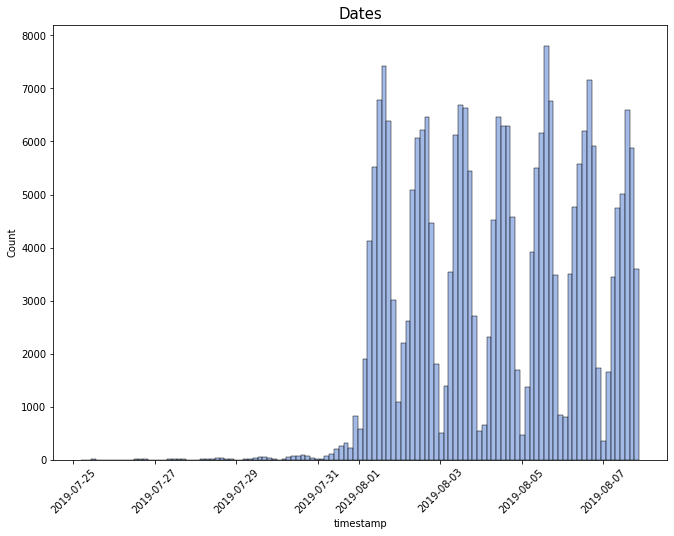

In [24]:
plt.figure(figsize=(11,8))
sns.histplot(food_data, x=food_data['timestamp'], color = '#85a3e0')
plt.xticks(rotation=45)
plt.title('Dates', fontsize=15);

Let's turn to this histogram. It shows us the dates when the data starts (min date is 25 July 2019, max - 07 August 2019) But as for data before August, there is clearly a lack of complete information. After 1st of August data behaves the same way.

In [25]:
food_data['timestamp'].min()

Timestamp('2019-07-25 04:43:36')

In [26]:
food_data['timestamp'].max()

Timestamp('2019-08-07 21:15:17')

As we mentioned above the really complete data is starting from the 1st of august. That means that the test actually started on that date, and we don't have a proper data before this date. The test actually run for a week and before august it could be a preparation for the test or some technical issues. To have a full analysis it is highly recommended to delete data that is before 1st of August.

In [27]:
out = food_data[(food_data['timestamp'] < '2019-08-01')]
out.head()

,event_name,user_id,timestamp,experiment_id,dates,time
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25,04:43:36
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25,11:11:42
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25,11:28:47
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25,11:28:47
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25,11:48:42


In [28]:
food_new = food_data.loc[~((food_data['user_id'].isin(out['user_id'])))]
food_new.head()

,event_name,user_id,timestamp,experiment_id,dates,time
2828,Tutorial,3737462046622621720,2019-08-01 00:07:28,246,2019-08-01,00:07:28
2829,MainScreenAppear,3737462046622621720,2019-08-01 00:08:00,246,2019-08-01,00:08:00
2830,MainScreenAppear,3737462046622621720,2019-08-01 00:08:55,246,2019-08-01,00:08:55
2831,OffersScreenAppear,3737462046622621720,2019-08-01 00:08:58,246,2019-08-01,00:08:58
2832,MainScreenAppear,1433840883824088890,2019-08-01 00:08:59,247,2019-08-01,00:08:59


In [29]:
food_new['experiment_id'].unique()

array([246, 247, 248])

After deleting the unnecessary dates we still have all 3 groups presented.

In [30]:
events_food_new = food_new.groupby(['user_id'])['event_name'].nunique().reset_index()['event_name'].value_counts()
events_food_new 

4    2375
1    2151
2     846
5     462
3     266
Name: event_name, dtype: int64

Now the mainscreen is the top for 2151 users and  paymentscreen successful appeared for 2375 users.

In [31]:
users_new = food_new['user_id'].nunique()
users_new 

6100

There are 6100 users remaining in the new database.

In [32]:
share_events=events_food_new /events_food
share_events

4    0.782537
1    0.794607
2    0.828599
5    0.980892
3    0.839117
Name: event_name, dtype: float64

In [33]:
share_users=users_new / users
share_users

0.8078400211892465

In [34]:
food_new.groupby(['experiment_id'])['user_id'].nunique().reset_index()

,experiment_id,user_id
0,246,2030
1,247,2036
2,248,2034


After excluding the data we still have 81% of users remaining in the new database. We have users from all 3 groups. As for events: approximately 80% of events are there in the new data base.

# STEP 4. Event funnel 

For the further investigation we need to study the events that are in the logs and their frequency of occurrence. 

In [35]:
food_new.groupby(['event_name'])['user_id'].count().sort_values(ascending=False)

event_name
MainScreenAppear           88913
OffersScreenAppear         35963
CartScreenAppear           32304
PaymentScreenSuccessful    25748
Tutorial                    1025
Name: user_id, dtype: int64

The most frequently we see the mainscreen appear log, the second is the offersscreen and actually the payment is on the 4th place out of 5 possible.

We are going to detect the number of users who performed each of these actions and sort the events by the number of users. 

In [36]:
food_new.groupby(['event_name'])['user_id'].nunique().sort_values(ascending=False)

event_name
MainScreenAppear           6017
OffersScreenAppear         3739
CartScreenAppear           3014
PaymentScreenSuccessful    2852
Tutorial                    829
Name: user_id, dtype: int64

From the table above we identified that 6017 users performed mainscreen and only 2852 payd the offer.

In [37]:
food_new.groupby(['event_name'])['user_id'].nunique().sort_values(ascending=False)/food_new['user_id'].nunique()

event_name
MainScreenAppear           0.986393
OffersScreenAppear         0.612951
CartScreenAppear           0.494098
PaymentScreenSuccessful    0.467541
Tutorial                   0.135902
Name: user_id, dtype: float64

The share of the users that had mainscreen is allmost 99%, the payment screen is 46% of users.
Now we can study the sequence of events for some users.

In [38]:
sorted_data=food_new[food_new['event_name']!='Tutorial'].sort_values(by=['user_id','timestamp'])

In [39]:
sorted_data.sample(2)

,event_name,user_id,timestamp,experiment_id,dates,time
15172,OffersScreenAppear,6932517045703054087,2019-08-01 10:56:52,248,2019-08-01,10:56:52
5672,MainScreenAppear,2988069914968447512,2019-08-01 05:37:23,246,2019-08-01,05:37:23


In [40]:
def sequence(user):
    sorted_user=sorted_data[sorted_data['user_id']==user].sort_values(by=['user_id','timestamp'])
    return sorted_user['event_name'].drop_duplicates().to_list()

In [41]:
sequence(7002515446915619058)

['MainScreenAppear',
 'OffersScreenAppear',
 'CartScreenAppear',
 'PaymentScreenSuccessful']

In [42]:
sequence(2747519232871077339)

['MainScreenAppear',
 'CartScreenAppear',
 'OffersScreenAppear',
 'PaymentScreenSuccessful']

In [ ]:
sequence_empty=[]
for i in sorted_data.user_id.unique():
    sequence_empty.append([i,sequence(i)])

If we want to trace the path that the users commonly have we can built it this way.

In [ ]:
path_data=pd.DataFrame(sequence_empty, columns=['user','path'])
path_data.head()

In [ ]:
path_data['path'].values_count().head()

So now we can describe the path for the users the following way:
The most popular one is still just 'MainScreenAppear', however the next one is 'MainScreenAppear, OffersScreenAppear, CartScreenAppear, PaymentScreenSuccessful',which includes payment and the 3rd is again - 'MainScreenAppear, OffersScreenAppear' without cart or payment here.

Building the event funnel is helping us to find the share of users that proceed from each stage to the next.

In [ ]:
funnel=food_new.groupby(['event_name'])['user_id'].nunique().sort_values(ascending=False).reset_index()
funnel.drop(funnel[funnel.event_name=='Tutorial'].index,inplace=True)
funnel

In [ ]:
funnel['perc']=funnel['user_id'].pct_change()
funnel

To illustrate the precent of loss let's take a look at the above table. We notice that 37% less users goes from mainscreen to the offers screen, 20% more we loose from the offers page to cart page and else 5% don't procced to check out.

In [ ]:
funnel_groups=[]
for i in food_new['experiment_id'].unique():
    group=food_new[food_new.experiment_id==i].groupby(['event_name','experiment_id'])['user_id'].nunique().reset_index().sort_values(by='user_id',ascending=False)
    group.drop(group[group.event_name=='Tutorial'].index,inplace=True)
    display(group)
    funnel_groups.append(group)

In [ ]:
funnel_groups_246_247 = funnel_groups[0].set_index('event_name').add(funnel_groups[1].set_index('event_name'), fill_value=0).reset_index()
funnel_groups_246_247_248 = pd.concat([funnel_groups_246_247, funnel_groups[2]])
funnel_groups_246_247_248

In [ ]:
funnel_groups=pd.concat(funnel_groups)
funnel_groups

In [ ]:
fig=px.funnel(funnel_groups,x='user_id',y='event_name',color='experiment_id', width=800, height=500)
fig.update_layout(
    title="Event funnel for experimental groupse",
    xaxis_title="user_id",
    yaxis_title="event_name",
    legend_title="experiment_id")
fig.show()

In [ ]:
for group in [246, 247, 248]:
    new_df = funnel_groups[funnel_groups['experiment_id'] == group]
    print(f"share group {group} = {new_df.at[3, 'user_id'] / new_df.at[1, 'user_id']}")
    
    

Studying the share of users that make the entire journey from their first event to payment - we have the result of 47% fow every group.

# Step 5. The results of the experiment
1. The quantity of users in new database

In [ ]:
food_1 = food_new.groupby(['experiment_id'])['user_id'].nunique()
food_1

We see that there are approximately 2000 users in every group. There is no difference between groups, so we can declare that they splited equally and normal within 3 groups.

In [ ]:
food_new.groupby(['user_id'])['experiment_id'].nunique().reset_index().query('experiment_id>1')

There are no users that are presented in 2 groups the same time.

In [ ]:
test_1=food_new[food_new.experiment_id==246]['user_id'].unique()
test_2=food_new[food_new.experiment_id==247]['user_id'].unique()
test_3=food_new[food_new.experiment_id==248]['user_id'].unique()

In [ ]:
pivot=food_new.pivot_table(index='event_name',columns='experiment_id', values='user_id', aggfunc=lambda x:x.nunique()).reset_index()

In [ ]:
pivot

In [ ]:
pivot_2=funnel_groups_246_247_248.pivot_table(index='event_name',columns='experiment_id', values='user_id').reset_index(
)

In [ ]:
pivot_2

Checking the hypothesis:

Null Hypothesis : There is no difference between 2 groups
Alternative Hypothesis: There is difference between 2 groups

In [ ]:
def check_hypothesis(group1,group2,event,alpha=0.05):
    success1=pivot[pivot.event_name==event][group1].iloc[0]
    success2=pivot[pivot.event_name==event][group2].iloc[0]
    
    trials1=food_new[food_new.experiment_id==group1]['user_id'].nunique()
    trials2=food_new[food_new.experiment_id==group2]['user_id'].nunique()
    
    p1=success1/trials1
    p2=success2/trials2
    
    p_combined = (success1+success2) / (trials1+trials2)
    
    difference=p1-p2
    
    z_value = difference/ mth.sqrt(p_combined *(1-p_combined) * (1/trials1 + 1/trials2))
    
    distr = st.norm(0,1)

    p_value = (1-distr.cdf(abs(z_value))) *2
    print('p_value', p_value)

    if(p_value < alpha):
        print("Rejecting the null hypothesis for", event, 'in groups', group1, group2)
    else:
        print("Failed to reject the null hypothesis for", event, 'in groups', group1, group2)

In [ ]:
trials1=food_new[food_new.experiment_id==246]['user_id'].nunique()
trials1

In [ ]:
trials2=food_new[food_new.experiment_id==247]['user_id'].nunique()
trials2

In [ ]:
trials1_2=trials1+trials2
trials1_2

In [ ]:
trials3=food_new[food_new.experiment_id==248]['user_id'].nunique()
trials3

Selecting the most popular event. In each of the control groups, we should find the number of users who performed this action, to find their share, to check whether the difference between the groups is statistically significant, then  repeat the procedure for all other events 
As we already checked the most popular event is Mainscreenappear. Let's check the hypothesis within 246 and 247 groups for that event.

In [ ]:
check_hypothesis(246,247, 'MainScreenAppear', alpha=0.05)

We can conclude that that the 2 groups are equally devided with the same proportions. Now we are able to check the same hypothesis for other groups and events.

In [ ]:
for i in pivot.event_name.unique():
    check_hypothesis(246,247,i,alpha=0.05)

The groups were split correctly.

In [ ]:
for i in pivot.event_name.unique():
    check_hypothesis(246,248,i,alpha=0.05)

In [ ]:
for i in pivot.event_name.unique():
    check_hypothesis(247,248,i,alpha=0.05)

In [ ]:
def check_hypothesis_new(df,group1,group2,event,alpha=0.05):
    success1=df.query('experiment_id == @group1 and event_name == @event').user_id.nunique()
    success2=df.query('experiment_id == @group2 and event_name == @event').user_id.nunique()
    
    trials1=df.query('experiment_id == @group1').user_id.nunique()
    trials2=df.query('experiment_id == @group2').user_id.nunique()

    p1 = success1/trials1
    p2 = success2/trials2
    
    p_combined = (success1+success2) / (trials1+trials2)
    
    difference = p1-p2
    
    z_value = difference/ mth.sqrt(p_combined *(1-p_combined) * (1/trials1_2 + 1/trials3))
    
    distr = st.norm(0,1)

    p_value = (1-distr.cdf(abs(z_value))) *2
    print('p_value', p_value)

    if(p_value < alpha):
        print("Rejecting the null hypothesis for", event, 'in groups', group1, group2)
    else:
        print("Failed to reject the null hypothesis for", event, 'in groups', group1, group2)
        
for i in pivot_2.event_name.unique():
    check_hypothesis_new(food_new,[246,247],248,i,alpha=0.05)    

As we are making a proportion tests several times, we checked the equalty of groups devided, we checked all the proportions by events by groups seperately with each other, the 246 and the 248 group, the 247 and the 248 group, both 246 and 247 to 248 group, the results were the same and they are not changing as we have no need to make the Bonferroni correction to decrease the type 1 error in our test, because when we decrease the type 1 error we increase the number of type II errors.

# Conclusion

We made an analysis for a food selling company. The data base had the information since 25 of July till 07 August, it contained 3 groups of users that were on the experiment. As we moved on we figured out that the data before 1st of August is incomplete, so we decided to study only the data from August. There were no missing values, also no users were on the 2 groups at the same time, but we had a lot of duplicated rows for whole number of events and groups. 
Analysing the users behaviour it became clear that the most popular event that occured was mainscreenappear and only 13% converted and made the whole path from mainscreen to payment. 
Analysing the proportions that we had for the events and groups seperately there were no difference between proportions for all the events and groups and there was a difference when we united 246 and 247 groups and compared it to 248. 